# Solving the Poisson problem using the Discontinuous Galerkin method
Author: Jørgen S. Dokken

Updated on 2023/09/12 by Evans L. Molel

In this section, we will go through how to solve the Poisson problem from the [Fundamentals](fundamentals.ipynb) tutorial using Discontinuous Galerkin (DG) method.
As opposed to using Continuous Lagrangian finite elements, we will now use finite elements that only span the element they are defined on. 

We start by importing the required modules and creating the mesh and function space for our solution

In [1]:
%matplotlib ipympl
import dolfinx
import ipympl
import numpy
from dolfinx import cpp, fem, io, mesh, nls, plot
from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 div, dx, ds, dS, grad, inner, grad, avg, jump)

N = 8   
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N)
V = fem.FunctionSpace(domain, ("DG", 1))

We start by comparing this function space to our standard finite element space.

In [2]:
V_CG = fem.FunctionSpace(domain, ("CG", 1))
print(f"Num DG dofs: {V.dofmap.index_map.size_local}")
print(f"Num CG dofs: {V_CG.dofmap.index_map.size_local}")

Num DG dofs: 384
Num CG dofs: 81


We note that we have alot of extra degrees of freedom using the discontinuous function space. This is because element in the mesh has its own degrees of freedom equal to the number of vertices, while the CG function space has as many dofs as there are unique vertices in the mesh.

In [3]:
print(f"Num cells: {domain.topology.index_map(domain.topology.dim).size_local}")
print(f"Num vertices: {domain.topology.index_map(0).size_local}")
cell_to_vertex = domain.topology.connectivity(domain.topology.dim, 0)
print(f"Num vertices per cell: {cell_to_vertex.links(0).size}")

Num cells: 128
Num vertices: 81
Num vertices per cell: 3


Next, we create a function containing the exact solution (which will also be used in the Dirichlet boundary condition) and the corresponding source function for the right hand side.

In [4]:
uD = fem.Function(V)
a = 0.8
c = 1
uD.interpolate(lambda x: 1 + a * x[0]**2 + c * x[1]**2)
uD.x.scatter_forward()
x = SpatialCoordinate(domain)
f = -div(grad(1 + a * x[0]**2 + c * x[1]**2))

As in the [Nitsche tutorial](nitsche.ipynb) we have another look at the variational formulation.
We start by dividing the integral over the computational domain $\Omega$ into an integral over each cell $K$.
\begin{align}
    \int_{\Omega} -\nabla^2 u \cdot v~\mathrm{d}x = \sum_{i=1}^{\text{num cells}} \int_{K_i}\nabla^2 u \cdot v ~\mathrm{d}x
\end{align}
Using integration by parts, we obtain
\begin{align}
    \int_{\Omega} -\nabla^2 u \cdot v~\mathrm{d}x =\sum_{i=1}^{\text{num cells}}\left( \int_{K_i}\nabla u \cdot \nabla v ~\mathrm{d}x
    - \int_{\partial K_i} (n \cdot \nabla u ) \cdot v ~\mathrm{d}s \right)
\end{align}
We now split the boundary $\partial K_i$ into two parts, the part where $\partial K_i \subset \partial \Omega$, and where $\partial K_i$ is an internal boundary (denoted $\partial\hat K_i)$. We now use the restriction $u_i$ to mean the function belonging to the cell $K_i$, and use that the volume integral is equal to then integral over the whole domain $\Omega$.
\begin{align}
    \int_{\Omega} -\nabla^2 u \cdot v~\mathrm{d}x =&\int_{\Omega}\nabla u \cdot \nabla v ~\mathrm{d}x - \int_{\partial \Omega} (n\cdot \nabla u ) \cdot v ~\mathrm{d}s \\
    -&\sum_{i=1}^{\text{num cells}}\left(\int_{\partial \hat K_i} (n_i \cdot \nabla u_i ) \cdot v_i ~\mathrm{d}s \right) 
 \end{align}
 We note that for the last term, we have an integral for each side of the integral facet, say between cell $i$ and $j$. We can therefore write this integral as a jump integral (noting that $n_i=-n_j$) over the set of all interal facets $E_j, j=0,\dots,\text{num internal facets}$
\begin{align}
 -\sum_{i=1}^{\text{num cells}}\int_{\partial \hat K_i} (n_i \cdot \nabla u_i ) \cdot v_i ~\mathrm{d}s &=
 \sum_{j=1}^{\text{num internal facets}} \int_{E_j} n_j\cdot[\nabla u\cdot v]~\mathrm{d}s,
 \end{align}
 where $[u]= u_{j,1}-u_{j,2}$ where $u_{j,1}$ and $u_{j,2}$ is the restriction to each cell connected to the facet $E_j$. We then use that $[uv]=\langle u \rangle [v] +[u] \langle v \rangle$ where $\langle u \rangle= 0.5(u_{j,1}+u_{j,2})$ is the average of the two functions at the edge.
 Thus, we can write 
\begin{align}
  \sum_{j=1}^{\text{num internal facets}} \int_{E_j} n_j\cdot[\nabla u\cdot v]~\mathrm{d}s=\sum_{j=1}^{\text{num internal facets}} \int_{E_j}n_j \cdot ([\nabla u]\cdot\langle v \rangle +\langle\nabla u\rangle \cdot [v])~\mathrm{d}s.
\end{align}
In the setting of continuous finite elements, we would have that $[u]=[v]=0$. However, as we will be using discontinuous finite elements, this is no longer guaranteed. However, we enforce that the jump of the gradient in normal direction is $0$ over each internal facet by removing the integral from the variational form, i.e.
\begin{align}
 \sum_{j=1}^{\text{num internal facets}} \int_{E_j} n_j\cdot[\nabla u\cdot v]~\mathrm{d}s=\sum_{j=1}^{\text{num internal facets}} \int_{E_j}n_j \cdot \langle\nabla u\rangle \cdot [v]~\mathrm{d}s.
\end{align}
    As in the [Nitsche tutorial](nitsche.ipynb) we add one term for symmetry, $\int_{E_j}n_j \cdot \langle\nabla v\rangle \cdot [u]~\mathrm{d}s$ and one term for coercivity $\int_{E_j}\frac{\gamma}{\langle h \rangle}[u][v]~\mathrm{d}s$ where $h$ is the diameter of the circumscribed circle. See {}`arnoldanalysis` for more details.

To impose the exterior boundary condition, we use Nitsche's method, as described in [Nitsche](nitsche.ipynb). 
This means that we arrive at:

In [5]:
u = TrialFunction(V)
v = TestFunction(V)
n = FacetNormal(domain)
h = 2 * Circumradius(domain)
alpha = 10
gamma = 10
h_avg = avg(h)

a = inner(grad(u), grad(v)) * dx - inner(n, grad(u)) * v * ds
# Add DG/IP terms
a += - inner(avg(grad(v)), jump(u, n)) * dS - inner(jump(v, n), avg(grad(u))) * dS
a += + (gamma / h_avg) * inner(jump(v, n), jump(u, n)) * dS

# Add Nitsche terms
a += - inner(n, grad(v)) * u * ds + alpha / h * inner(u, v) * ds
L = inner(f, v) * dx 
L += - inner(n, grad(v)) * uD * ds + alpha / h * inner(uD, v) * ds

We note that in DOLFINx, we use `dS` to integrate over internal facets, while `ds` is used for exterior facets.

As we now have the variational form, we can solve the linear problem

In [6]:
problem = fem.petsc.LinearProblem(a, L)
uh = problem.solve()

We compute the error of the computation by comparing it to the analytical solution

In [7]:
error_form = fem.form(inner(uh - uD, uh - uD) * dx)
errorL2 = numpy.sqrt(fem.assemble_scalar(error_form))
print(fr"$L^2$-error: {errorL2:.2e}")

$L^2$-error: 9.93e-04


We observe that the $L^2$-error is of the same magnitude as in the first tutorial.
As in the previous tutorial, we also compute the error at the mesh vertices

In [8]:
u_vertex_values = uh.x.array.real
u_ex_vertex_values = uD.x.array.real
error_max = numpy.max(numpy.abs(u_vertex_values - u_ex_vertex_values))
print(f"Error_max : {error_max:.2e}")

Error_max : 3.30e-03


We observe that as we weakly impose the boundary condition, we no longer fullfill the equation to machine precision at the mesh vertices. We also plot the solution using `pyvista`, where we visualize each degree of freedom. This implies that at each vertex of the mesh there are as many degrees of freedom as there are number of cells using this vertex.


No module named 'trame.app'

Falling back to a static output.
  warnings.warn(



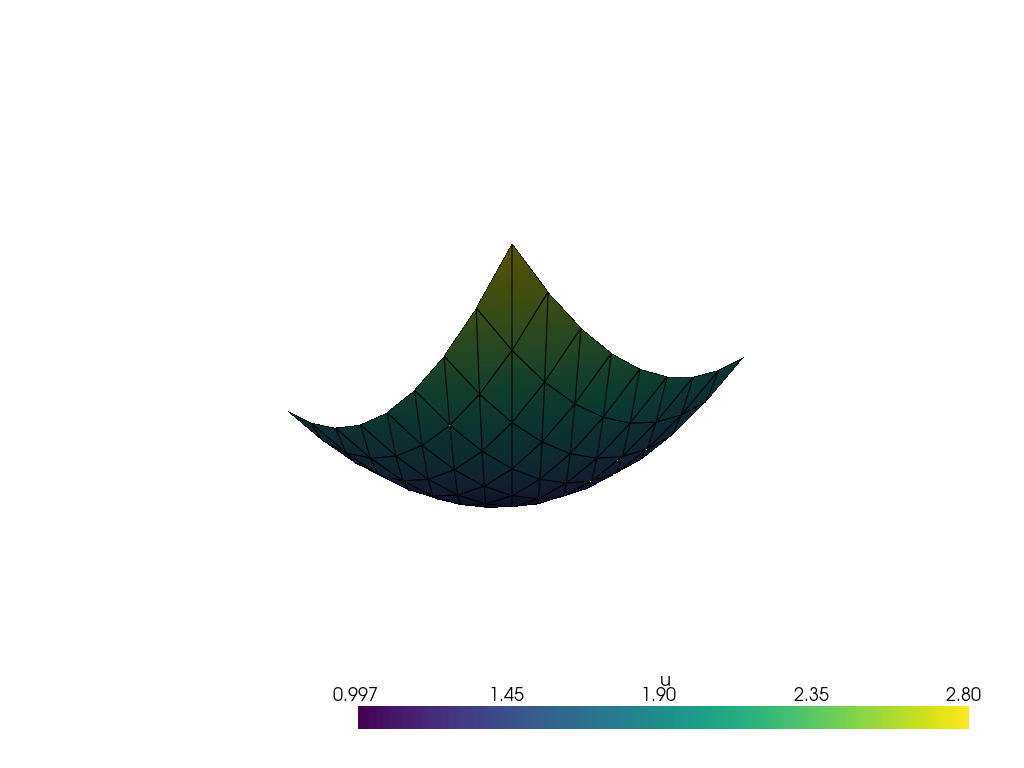

In [9]:
import pyvista

# pyvista.set_jupyter_backend('pythreejs')
pyvista.start_xvfb()
# We create a mesh consisting of the degrees of freedom for visualization
topology, cell_types, x = plot.create_vtk_mesh(V)
num_dofs_local = V.dofmap.index_map.size_local
grid = pyvista.UnstructuredGrid(topology, cell_types, V.tabulate_dof_coordinates()[:num_dofs_local])
# To make this function work in parallel, we only consider dofs owned by the current process
grid.point_data["u"] = uh.vector.array.real
grid.set_active_scalars("u")
warped = grid.warp_by_scalar("u", factor=1)

# Create plotter
plotter = pyvista.Plotter()
pyvista.start_xvfb(wait=0.05)
plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("DG.png")

```{bibliography}
   :filter: cited and ({"chapter1/dg"} >= docnames)
```